# Introduction
This is an experiment to determine whether dimensional reduction with principal component analysis increases accuracy and decreases training time of machine learning classification algorithms, or makes it worse. 

The dataset used in this machine learning experiment is the MNIST784 dataset which is a dataset of pixel darkness values of a of a 28x28 grid of images of handwritten numbers written by children, and photographed. **Dimensional reduction reduces computation time** by reducing the number of dimensions the classifiers are trained with and use for classification and hence the number of operations the machine needs to run. As there are 784 dimensions (1 for each pixel) in the dataset - which is many - there is large potential for dimensional reduction to improve machine learning training time and classification accuracy.

The classifiers attempt to classify the number in the image the drawing was taken of by being trained on the label data provided in the first column.

The algorithms tested are made up of tree based methods and linear space methods
* decision tree
* random forest
* stochastic gradient descent
* support vector machine
* xgboost
* k nearest neighbors 
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler #SS for pca
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#the sklearn version of gradient boost is unusable due its long training time as it does not supprt multithreading
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier #scale data and tune
import xgboost as xgb 
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train = pd.read_csv('data/mnist_train.csv', header='infer')
test = pd.read_csv('data/mnist_test.csv', header='infer')

In [3]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train.isna().any().sum())
print(test.isna().any().sum())

0
0


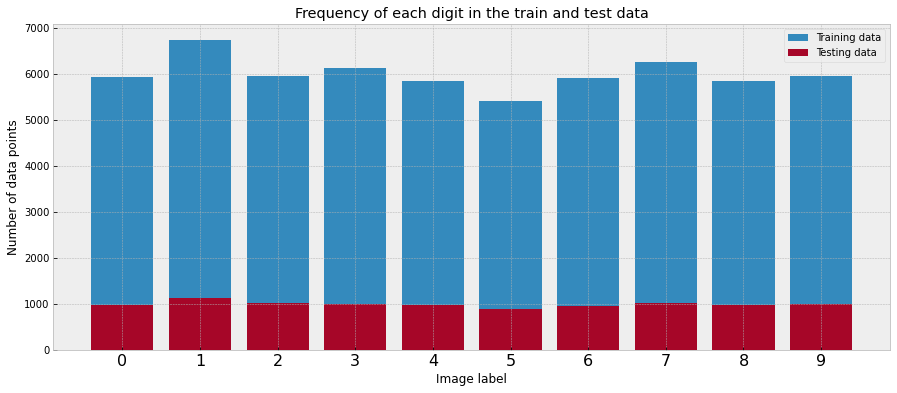

In [5]:
train_f = train.groupby('label')['label'].count()
test_f = test.groupby('label')['label'].count()

plt.rcParams['figure.figsize']=(15, 6) 
plt.rc('font', size=10)

fig, ax = plt.subplots()
ax.bar(train_f.index, train_f, label='Training data')
ax.bar(test_f.index, test_f, label='Testing data')
ax.set_xlabel("Image label")
ax.set_ylabel("Number of data points")
ax.set_title('Frequency of each digit in the train and test data')
ax.legend()
plt.xticks(ticks=np.arange(10), labels=['0','1','2','3','4','5','6','7','8','9'], fontsize=16)
plt.show()

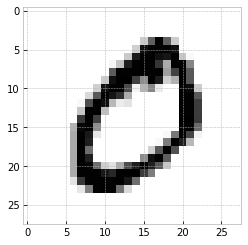

In [6]:
plt.rcParams['figure.figsize']=(4, 4) 
some_digit = train.iloc[1,1:].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.show()

In [7]:
print(train.iloc[1,1:])

1x1      0
1x2      0
1x3      0
1x4      0
1x5      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 1, Length: 784, dtype: int64


In [3]:
x_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

x_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [4]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_ = scaler.transform(x_train)

scaler2 = StandardScaler()
scaler2.fit(x_test)
x_test_ = scaler2.transform(x_test)

In [20]:
pca_res = {'percentage of variance':[],'number of features (from 784)':[], 'D tree training time':[], 'Accuracy':[]}

In [21]:
unusedDT = DecisionTreeClassifier()
for t in [None, .95, .9, .75, .5]: #None is 100% of the variance
    pca = PCA(t)
    pca.fit(x_train_)
    pca_train = pca.transform(x_train_)
    pca_test = pca.transform(x_test_)
    
    start_time = time.time()
    unusedDT.fit(pca_train, y_train)
    timetaken = round(time.time()-start_time, 2)
    a = accuracy_score(y_test, unusedDT.predict(pca_test))
    
    pca_res['percentage of variance'].append(t)
    pca_res['number of features (from 784)'].append(pca_train.shape[1])
    pca_res['D tree training time'].append(timetaken)
    pca_res['Accuracy'].append(a)

In [22]:
pca_df = pd.DataFrame(pca_res)
pca_df

,percentage of variance,number of features (from 784),D tree training time,Accuracy
0,NaN,784,142.10,0.8140
1,0.95,331,62.17,0.8235
2,0.90,236,43.58,0.8274
3,0.75,120,20.90,0.8329
4,0.50,39,6.66,0.8467


Amount of variance explained by features


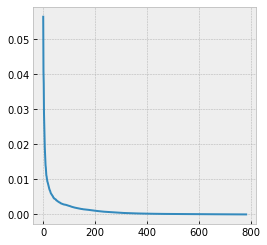

In [19]:
pca2 = PCA().fit(x_train_)
pca2_train = pca2.transform(x_train_)
print('Amount of variance explained by features')
plt.plot(pca2.explained_variance_ratio_)
plt.show()

### Results

The training time is more than halved at 0.95 variance while actually improving accuracy. This is the threshold I will use.

There are unusual results in this experiment. It seems that reducing the dimensions down to 39 where only 50% of the variance remains results in the most accurate classification. 

### Explanation of results
The results would suggest that reducing the dimensions to 39 is the best approach, however I eschew that notion because it is probably because there is a bias in the decision tree classifier towards accurtely predicting the images(0-9) that starts from 0.9-0.75 since the accuracy counterintuitively starts to go up. This would not well in the other algorithms, and could be extremely deleterious for putting this into production. However it may be promising for K means clustering later on which does not perform well on high dimensional datasets.

## Dimensional reduction with PCA
Data has already been scaled in the above cells

In [5]:
pca = PCA(.95)
pca.fit(x_train_)
pca_train = pca.transform(x_train_)
pca_test = pca.transform(x_test_)

In [6]:
print(pca_train.shape[1])
print(pca_test.shape[1])

331
331


## Decision Tree

In [13]:
a0 = DecisionTreeClassifier()
start_time = time.time()
a0.fit(x_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a0.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a0.predict(x_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken without PCA: 19.05S
training accuracy: 1.0
testing accuracy: 0.8791


In [14]:
a0 = DecisionTreeClassifier()
start_time = time.time()
a0.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken with PCA: {timetaken}S')

y_hat = a0.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a0.predict(pca_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken with PCA: 57.5S
training accuracy: 1.0
testing accuracy: 0.8265


## Random Forest

In [28]:
a1 = RandomForestClassifier()
start_time = time.time()
a1.fit(x_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a1.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a1.predict(x_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken without PCA: 41.6S
training accuracy: 1.0
testing accuracy: 0.9708


In [29]:
a1 = RandomForestClassifier()
start_time = time.time()
a1.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken with PCA: {timetaken}S')

y_hat = a1.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a1.predict(pca_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken with PCA: 135.75S
training accuracy: 1.0
testing accuracy: 0.9371


## Stochastic Gradient Descent
- SGD is very sensitive to parameter tuning and feature scaling

In [29]:
a3 = SGDClassifier(n_jobs=8)
start_time = time.time()
a3.fit(x_train_, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a3.predict(x_train_)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = a3.predict(x_test_)
print(f'testing accuracy: {accuracy_score(y_test, Y_hat)}')

time taken without PCA: 111.88S
training accuracy: 0.9046
testing accuracy: 0.9006


In [5]:
steps = [('scaler',StandardScaler()), 
         ('sgd',SGDClassifier(n_jobs=8))]
pipeline = Pipeline(steps)

# There should be two underscores between estimator name and it's parameters in a Pipeline

param = {'sgd__loss':['hinge','epsilon_insensitive'], # Not working with loss
         'sgd__penalty':['elasticnet'], # no l1 as features already reduced
         'sgd__alpha':np.arange(0.00001, 0.001, 5),
         'sgd__l1_ratio':np.arange(0, 1, 5),
         'sgd__max_iter':[500,1000],
         'sgd__eta0':[0.001],   #initial learning rate
         'sgd__learning_rate':['constant','optimal'],
         'sgd__power_t':[0.25,0.50,0.75],
         'sgd__early_stopping':[True],
         'sgd__n_iter_no_change':[15]}

pipelinecv = GridSearchCV(pipeline, param_grid=param, scoring='accuracy')
pipelinecv.fit(x_train, y_train)
print(pipelinecv.best_estimator_.get_params)

y_hat = pipelinecv.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = pipelinecv.predict(x_test)
print(f'testing accuracy: {accuracy_score(y_test, Y_hat)}')

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=1e-05, early_stopping=True, eta0=0.001,
                               l1_ratio=0, n_iter_no_change=15, n_jobs=8,
                               penalty='elasticnet', power_t=0.25))])>
training accuracy: 0.9195333333333333
testing accuracy: 0.9123


In [30]:
a3 = SGDClassifier(n_jobs=8)

start_time = time.time()
a3.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken: {timetaken}S')
   
y_hat = a3.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = a3.predict(pca_test)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')

time taken: 12.18S
training accuracy: 0.8410166666666666
training accuracy: 0.844


In [50]:
a3 = SGDClassifier(n_jobs=8)

param = {'loss':['hinge','epsilon_insensitive'], # Not working with loss
         'penalty':['elasticnet'], # no l1 as features already reduced
         'alpha':np.arange(0.00001, 0.001, 5),
         'l1_ratio':np.arange(0, 1, 5),
         'max_iter':[500,1000],
         'eta0':[0.001],   #initial learning rate
         'learning_rate':['constant','optimal'],
         'power_t':[0.25,0.50,0.75],
         'early_stopping':[True],
         'n_iter_no_change':[15]}

a3cv = GridSearchCV(a3, param_grid=param, scoring='accuracy')
a3cv.fit(pca_train, y_train)
print(a3cv.best_estimator_.get_params)
y_hat = a3cv.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = a3cv.predict(pca_test)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')

<bound method BaseEstimator.get_params of SGDClassifier(alpha=1e-05, early_stopping=True, eta0=0.001, l1_ratio=0,
              learning_rate='constant', n_iter_no_change=15, n_jobs=8,
              penalty='elasticnet', power_t=0.25)>
training accuracy: 0.9162
training accuracy: 0.9147


## XGBoost

In [7]:
a4 = xgb.XGBClassifier(use_label_encoder=False, nthread=4, verbosity=0)
start_time = time.time()
a4.fit(x_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')
   
y_hat = a4.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = a4.predict(x_test)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')

time taken without PCA: 533.82S


D:\INSTALLATION_FOLDER\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


training accuracy: 1.0
training accuracy: 0.9729


In [30]:
a4 = xgb.XGBClassifier(use_label_encoder=False, nthread=4, verbosity=0)

start_time = time.time()
a4.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken with PCA: {timetaken}S')
   
y_hat = a4.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
Y_hat = a4.predict(pca_test)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')

time taken with PCA: 1824.36S
training accuracy: 1.0
training accuracy: 0.9595


## Support vector machine

In [7]:
a5 = SVC()
start_time = time.time()
a5.fit(x_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a5.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a5.predict(x_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken without PCA: 466.15S
training accuracy: 0.9899166666666667
testing accuracy: 0.9792


In [8]:
a5 = SVC()
start_time = time.time()
a5.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken with PCA: {timetaken}S')

y_hat = a5.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a5.predict(pca_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken with PCA: 340.6S
training accuracy: 0.9854666666666667
testing accuracy: 0.9679


## K nearest neighbours
Tested with different scaling methods on the non reduced data. Algorithsm has been set to brute to standardize the experiment
- Normalized data
- Standardized data
- Pca reduced data

In [18]:
steps = [('scaler',MinMaxScaler()), ('knn',KNeighborsClassifier(algorithm='brute', n_jobs=8))]
pipelineb1 = Pipeline(steps)
pipelineb1.fit(x_train, y_train)

start_time = time.time()
y_hat = pipelineb1.predict(x_train)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
print(f'time taken to predict training data: {timetaken}S')

start_time = time.time()
Y_hat = pipelineb1.predict(x_test)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')
print(f'time taken to predict training data: {timetaken}S')

training accuracy: 0.9818833333333333
time taken to predict training data: 174.16S
training accuracy: 0.9688
time taken to predict training data: 29.07S


In [19]:
steps = [('scaler',StandardScaler()), ('knn',KNeighborsClassifier(algorithm='brute', n_jobs=8))]
pipelineb1 = Pipeline(steps)
pipelineb1.fit(x_train, y_train)

start_time = time.time()
y_hat = pipelineb1.predict(x_train)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
print(f'time taken to predict training data: {timetaken}S')

start_time = time.time()
Y_hat = pipelineb1.predict(x_test)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')
print(f'time taken to predict training data: {timetaken}S')

training accuracy: 0.96425
time taken to predict training data: 187.34S
training accuracy: 0.9443
time taken to predict training data: 32.06S


In [20]:
b1 = KNeighborsClassifier(algorithm='brute', n_jobs=8)
b1.fit(pca_train, y_train)

start_time = time.time()
y_hat = b1.predict(pca_train)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
print(f'time taken to predict training data: {timetaken}S')

start_time = time.time()
Y_hat = b1.predict(pca_test)
timetaken = round(time.time()-start_time, 2)
print(f'training accuracy: {accuracy_score(y_test, Y_hat)}')
print(f'time taken to train on test data: {timetaken}S')

training accuracy: 0.9675833333333334
time taken to predict training data: 163.1S
training accuracy: 0.9469
time taken to train on test data: 24.96S


# Results
With the exception of a mild difference in the KNN, the non-reduced data is more accurate in every case. 

With regards to training time, the results are divided. KNN, SGD, SVM train faster, with KNN only being mildly faster while the other tree based algorithms are significantly slower.

It is unknown why in the initial example of different variance parameters on PCA, the data without any dimensional reduction performed the worse. A possible explanation for this is that since the data was already scaled with the standard scaler, the scaled non-reduced data made the training time worse when unscaled data would perform the best.

The random forest experiment is tested again below
- RF with unscaled data
- RF with PCA reduced data
- RF with scaled data

In [21]:
a1 = RandomForestClassifier()
start_time = time.time()
a1.fit(x_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a1.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a1.predict(x_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken without PCA: 42.64S
training accuracy: 1.0
testing accuracy: 0.9687


In [22]:
a1 = RandomForestClassifier()
start_time = time.time()
a1.fit(pca_train, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken with PCA: {timetaken}S')

y_hat = a1.predict(pca_train)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a1.predict(pca_test)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken with PCA: 140.54S
training accuracy: 1.0
testing accuracy: 0.9363


In [23]:
a1 = RandomForestClassifier()
start_time = time.time()
a1.fit(x_train_, y_train)
timetaken = round(time.time()-start_time, 2)
print(f'time taken without PCA: {timetaken}S')

y_hat = a1.predict(x_train_)
print(f'training accuracy: {accuracy_score(y_train, y_hat)}')
y_hat = a1.predict(x_test_)
print(f'testing accuracy: {accuracy_score(y_test, y_hat)}')

time taken without PCA: 42.79S
training accuracy: 1.0
testing accuracy: 0.9596


# Conclusions
Scaling the data has a negligible effect on training time and accuracy in the random forest test.

Principal component analysis does not consistently improve the training time or accuracy of machine learning models. The accuracy is consistently worse to varying degrees, with the exception of linear space methods. While the change in training time is dependent on what type of algorithm is being used for classification; it can be concluded that PCA is definitively worse at affecting traiing time for tree based methods.